<a href="https://colab.research.google.com/github/mayraberrones94/FCFM/blob/master/Semana_2_Analisis_de_sentimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis de base de datos de Twitter

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Lectura de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-con-R/master/datos/'
tweets_elon   = pd.read_csv(url + "datos_tweets_@elonmusk.csv")
tweets_edlee  = pd.read_csv(url + "datos_tweets_@mayoredlee.csv")
tweets_bgates = pd.read_csv(url + "datos_tweets_@BillGates.csv")

print('Número de tweets @BillGates: ' + str(tweets_bgates.shape[0]))
print('Número de tweets @mayoredlee: ' + str(tweets_edlee.shape[0]))
print('Número de tweets @elonmusk: ' + str(tweets_elon.shape[0]))

Número de tweets @BillGates: 2087
Número de tweets @mayoredlee: 2447
Número de tweets @elonmusk: 2678


In [ ]:
# Se unen los dos dataframes en uno solo
tweets = pd.concat([tweets_elon, tweets_edlee, tweets_bgates], ignore_index=True)

# Se seleccionan y renombran las columnas de interés
tweets = tweets[['screen_name', 'created_at', 'status_id', 'text']]
tweets.columns = ['autor', 'fecha', 'id', 'texto']

# Parseo de fechas
tweets['fecha'] = pd.to_datetime(tweets['fecha'])
tweets.head(3)

,autor,fecha,id,texto
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, cho..."
1,elonmusk,2017-11-09 17:12:46+00:00,9.286717e+17,I placed the flowers\n\nThree broken ribs\nA p...
2,elonmusk,2017-11-08 18:55:13+00:00,9.283351e+17,Atatürk Anıtkabir https://t.co/al3wt0njr6


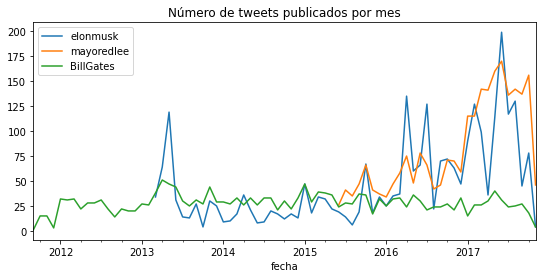

In [ ]:
# Distribución temporal de los tweets
# ==============================================================================
fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.autor.unique():
    df_temp = tweets[tweets['autor'] == autor].copy()
    df_temp['fecha'] = pd.to_datetime(df_temp['fecha'].dt.strftime('%Y-%m'))
    df_temp = df_temp.groupby(df_temp['fecha']).size()
    df_temp.plot(label=autor, ax=ax)

ax.set_title('Número de tweets publicados por mes')
ax.legend()

In [ ]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


In [ ]:
# Se aplica la función de limpieza y tokenización a cada tweet
# ==============================================================================
tweets['texto_tokenizado'] = tweets['texto'].apply(lambda x: limpiar_tokenizar(x))
tweets[['texto', 'texto_tokenizado']].head()

,texto,texto_tokenizado
0,"""If one day, my words are against science, cho...","[if, one, day, my, words, are, against, scienc..."
1,I placed the flowers\n\nThree broken ribs\nA p...,"[placed, the, flowers, three, broken, ribs, pi..."
2,Atatürk Anıtkabir https://t.co/al3wt0njr6,"[atatürk, anıtkabir]"
3,"@Bob_Richards One rocket, slightly toasted","[bob, richards, one, rocket, slightly, toasted]"
4,@uncover007 500 ft so far. Should be 2 miles l...,"[uncover, ft, so, far, should, be, miles, long..."


In [ ]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
tweets_tidy = tweets.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head(3)

,autor,fecha,id,token
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,if
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,one
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,day


In [ ]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='autor')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


autor
BillGates     31500
elonmusk      33609
mayoredlee    41878
Name: token, dtype: int64

In [ ]:
# Palabras distintas utilizadas por cada autor
# ==============================================================================
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


autor
BillGates     4848
elonmusk      6628
mayoredlee    5770
Name: token, dtype: int64

In [ ]:
# Longitud media y desviación de los tweets de cada autor
# ==============================================================================
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['mean', 'std'])

,mean,std
autor,,
BillGates,15.144231,3.347354
elonmusk,12.611257,6.933870
mayoredlee,17.170152,3.486314


In [ ]:
# Top 5 palabras más utilizadas por cada autor
# ==============================================================================
tweets_tidy.groupby(['autor','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('autor') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

autor token  count
autor                                    
BillGates  4195    BillGates   the   1178
           4271    BillGates    to   1115
           2930    BillGates    of    669
           2084    BillGates    in    590
           2207    BillGates    is    452
elonmusk   10699    elonmusk   the    983
           10816    elonmusk    to    913
           8859     elonmusk    of    638
           7801     elonmusk    is    542
           7656     elonmusk    in    476
mayoredlee 16650  mayoredlee    to   1684
           16568  mayoredlee   the   1338
           11669  mayoredlee   amp   1212
           14957  mayoredlee   our   1096
           15964  mayoredlee    sf    909

In [ ]:
nltk.download('stopwords')
# Obtención de listado de stopwords del inglés
# ==============================================================================
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [ ]:
# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

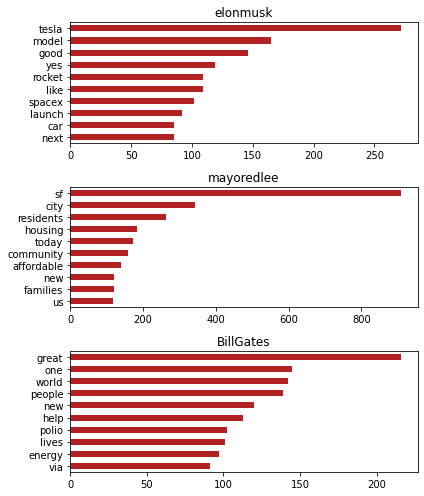

In [ ]:
# Top 10 palabras por autor (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(6, 7))
for i, autor in enumerate(tweets_tidy.autor.unique()):
    df_temp = tweets_tidy[tweets_tidy.autor == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout()

In [ ]:
# Pivotado de datos
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None

In [ ]:
# Test de correlación (coseno) por el uso y frecuencia de palabras
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

,BillGates,elonmusk,mayoredlee
BillGates,1.000000,0.567274,0.496346
elonmusk,0.567274,1.000000,0.276732
mayoredlee,0.496346,0.276732,1.000000


In [ ]:
# Descarga lexicon sentimientos
# ==============================================================================
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [ ]:
# Sentimiento promedio de cada tweet
# ==============================================================================
tweets_sentimientos = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "termino",
                            how      = "inner"
                      )

tweets_sentimientos = tweets_sentimientos.drop(columns = "termino")

# Se suman los sentimientos de las palabras que forman cada tweet.
tweets_sentimientos = tweets_sentimientos[["autor","fecha", "id", "sentimiento"]] \
                      .groupby(["autor", "fecha", "id"])\
                      .sum().reset_index()
tweets_sentimientos.head()

,autor,fecha,id,sentimiento
0,BillGates,2011-09-29 21:11:15+00:00,1.195196e+17,6
1,BillGates,2011-10-04 19:06:05+00:00,1.213001e+17,-3
2,BillGates,2011-10-06 00:37:29+00:00,1.217459e+17,3
3,BillGates,2011-10-06 00:38:09+00:00,1.217460e+17,6
4,BillGates,2011-10-19 22:12:21+00:00,1.267828e+17,3


In [ ]:
def perfil_sentimientos(df):
    print(autor)
    print("=" * 12)
    print(f"Positivos: {round(100 * np.mean(df.sentimiento > 0), 2)}")
    print(f"Neutros  : {round(100 * np.mean(df.sentimiento == 0), 2)}")
    print(f"Negativos: {round(100 * np.mean(df.sentimiento < 0), 2)}")
    print(" ")

for autor, df in tweets_sentimientos.groupby("autor"):
    perfil_sentimientos(df)

BillGates
Positivos: 79.88
Neutros  : 4.59
Negativos: 15.52
 
elonmusk
Positivos: 73.14
Neutros  : 4.29
Negativos: 22.57
 
mayoredlee
Positivos: 80.73
Neutros  : 4.07
Negativos: 15.2
 


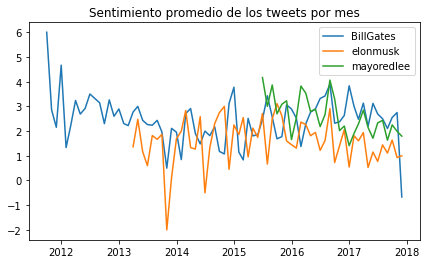

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4)) 

for autor in tweets_sentimientos.autor.unique():
    df = tweets_sentimientos[tweets_sentimientos.autor == autor].copy()
    df = df.set_index("fecha")
    df = df[['sentimiento']].resample('1M').mean()
    ax.plot(df.index, df.sentimiento, label=autor)

ax.set_title("Sentimiento promedio de los tweets por mes")
ax.legend()

# Usando base de datos Amazon Food Reviews

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Datasets/Reviews.csv')
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
dataset = df.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator'], axis =1)
dataset.head()

,Score,Time,Summary,Text
0,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
dataset.shape

(568454, 4)

In [ ]:
N = 567500
dataset = dataset.iloc[:-N , :]
dataset.shape

(954, 4)

In [ ]:
import re

# Define a function to clean the text
def clean(text):
    # Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text) 
    return text

# Cleaning the text in the review column
dataset['Cleaned Reviews'] = dataset['Text'].apply(clean)
dataset.head()

,Score,Time,Summary,Text,Cleaned Reviews
0,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,I have bought several of the Vitality canned d...
1,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled as Jumbo Salted Peanut...
2,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,This is a confection that has been around a fe...
3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,If you are looking for the secret ingredient i...
4,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Great taffy at a great price There was a wide ...


In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

dataset['POS tagged'] = dataset['Cleaned Reviews'].apply(token_stop_pos)
dataset.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Score,Time,Summary,Text,Cleaned Reviews,POS tagged
0,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,I have bought several of the Vitality canned d...,"[(bought, v), (several, a), (Vitality, n), (ca..."
1,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled as Jumbo Salted Peanut...,"[(Product, n), (arrived, v), (labeled, v), (Ju..."
2,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,This is a confection that has been around a fe...,"[(confection, n), (around, None), (centuries, ..."
3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,If you are looking for the secret ingredient i...,"[(looking, v), (secret, a), (ingredient, n), (..."
4,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Great taffy at a great price There was a wide ...,"[(Great, n), (taffy, n), (great, a), (price, n..."


In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:  
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew
    
dataset['Lemma'] = dataset['POS tagged'].apply(lemmatize)
dataset.head()

,Score,Time,Summary,Text,Cleaned Reviews,POS tagged,Lemma
0,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,I have bought several of the Vitality canned d...,"[(bought, v), (several, a), (Vitality, n), (ca...",buy several Vitality can dog food product fi...
1,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled as Jumbo Salted Peanut...,"[(Product, n), (arrived, v), (labeled, v), (Ju...",Product arrive label Jumbo Salted Peanuts pe...
2,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,This is a confection that has been around a fe...,"[(confection, n), (around, None), (centuries, ...",confection around century light pillowy citr...
3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,If you are looking for the secret ingredient i...,"[(looking, v), (secret, a), (ingredient, n), (...",look secret ingredient Robitussin believe fi...
4,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Great taffy at a great price There was a wide ...,"[(Great, n), (taffy, n), (great, a), (price, n...",Great taffy great price wide assortment yumm...


In [ ]:

dataset[['Text', 'Lemma']]

,Text,Lemma
0,I have bought several of the Vitality canned d...,buy several Vitality can dog food product fi...
1,Product arrived labeled as Jumbo Salted Peanut...,Product arrive label Jumbo Salted Peanuts pe...
2,This is a confection that has been around a fe...,confection around century light pillowy citr...
3,If you are looking for the secret ingredient i...,look secret ingredient Robitussin believe fi...
4,Great taffy at a great price. There was a wid...,Great taffy great price wide assortment yumm...
...,...,...
949,"I am a true Seattle coffee addict, and I have ...",true Seattle coffee addict never good coffee...
950,Sent this basket to my father for his birthday...,Sent basket father birthday say fruit fresh ...
951,This fruit gift really was the perfect gift! E...,fruit gift really perfect gift Everything fr...
952,I got it for my Girlfriend for her Birthday. ...,get Girlfriend Birthday Fruit actually taste...


# Analisis de sentimiento usando TextBlob

In [ ]:
from textblob import TextBlob

# function to calculate subjectivity 
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [ ]:
fin_data = pd.DataFrame(dataset[['Text', 'Lemma']])

In [ ]:
# fin_data['Subjectivity'] = fin_data['Lemma'].apply(getSubjectivity) 
fin_data['Polarity'] = fin_data['Lemma'].apply(getPolarity) 
fin_data['Analysis'] = fin_data['Polarity'].apply(analysis)
fin_data.head()

,Text,Lemma,Polarity,Analysis
0,I have bought several of the Vitality canned d...,buy several Vitality can dog food product fi...,0.466667,Positive
1,Product arrived labeled as Jumbo Salted Peanut...,Product arrive label Jumbo Salted Peanuts pe...,0.216667,Positive
2,This is a confection that has been around a fe...,confection around century light pillowy citr...,0.187000,Positive
3,If you are looking for the secret ingredient i...,look secret ingredient Robitussin believe fi...,0.150000,Positive
4,Great taffy at a great price. There was a wid...,Great taffy great price wide assortment yumm...,0.458333,Positive


In [ ]:
tb_counts = fin_data.Analysis.value_counts()
tb_counts

Positive    850
Negative     80
Neutral      24
Name: Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7fe30cb81110>,
 [Text(-1.0361172838763995, 0.36940624528098187, 'Positive'),
  Text(1.0037177872239293, -0.45005622272144985, 'Negative'),
  Text(1.3457859039158862, -0.10658471194923486, 'Neutral')],
 [Text(-0.5651548821143997, 0.20149431560780826, '89.1%'),
  Text(0.5474824293948705, -0.24548521239351806, '8.4%'),
  Text(0.8473466802433356, -0.0671088927087775, '2.5%')])

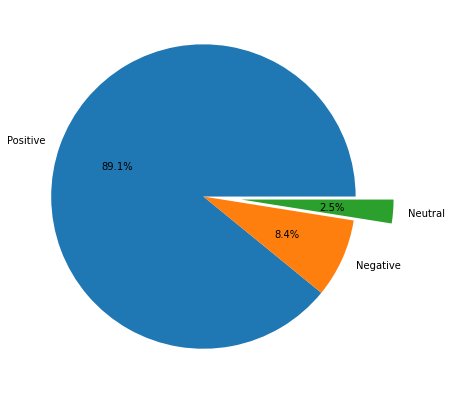

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

tb_count= fin_data.Analysis.value_counts()
plt.figure(figsize=(10, 7))
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)


# Analisis de sentimiento usando VADER

In [ ]:
!pip install vaderSentiment


     |████████████████████████████████| 125 kB 5.2 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment  
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

fin_data['Vader Sentiment'] = fin_data['Lemma'].apply(vadersentimentanalysis)

In [ ]:
# function to analyse 
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
    
fin_data['Vader Analysis'] = fin_data['Vader Sentiment'].apply(vader_analysis)
fin_data.head()

,Text,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,I have bought several of the Vitality canned d...,buy several Vitality can dog food product fi...,0.466667,Positive,0.9246,Positive
1,Product arrived labeled as Jumbo Salted Peanut...,Product arrive label Jumbo Salted Peanuts pe...,0.216667,Positive,-0.1027,Neutral
2,This is a confection that has been around a fe...,confection around century light pillowy citr...,0.187000,Positive,0.8532,Positive
3,If you are looking for the secret ingredient i...,look secret ingredient Robitussin believe fi...,0.150000,Positive,0.4404,Neutral
4,Great taffy at a great price. There was a wid...,Great taffy great price wide assortment yumm...,0.458333,Positive,0.9468,Positive


In [ ]:
vader_counts = fin_data['Vader Analysis'].value_counts()
vader_counts

Positive    773
Neutral     157
Negative     24
Name: Vader Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7fe30cd61f90>,
 [Text(-0.99307378543531, 0.6736500995926474, 'Positive'),
  Text(0.8587224254849581, -0.6874560320262166, 'Neutral'),
  Text(1.0965662880140177, -0.0868468536629785, 'Negative')],
 [Text(-0.5792930415039308, 0.392962558095711, '81.0%'),
  Text(0.4683940502645226, -0.3749760174688454, '16.5%'),
  Text(0.5981270661894641, -0.04737101108889735, '2.5%')])

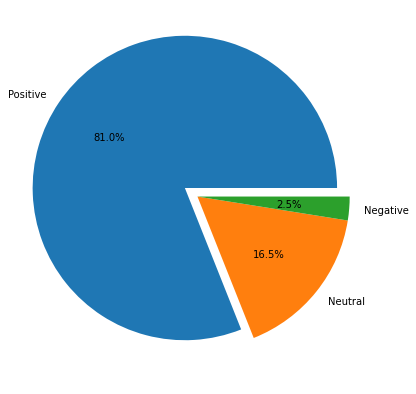

In [ ]:
vader_counts= fin_data['Vader Analysis'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
# plt.legend()

# Analisis using SentiWordNet

In [ ]:
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
    if not tokens_count:
        return 0
    if sentiment>0:
        return "Positive"
    if sentiment==0:
        return "Neutral"
    else:
        return "Negative"

fin_data['SWN analysis'] = dataset['POS tagged'].apply(sentiwordnetanalysis)
fin_data.head()

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


,Text,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis
0,I have bought several of the Vitality canned d...,buy several Vitality can dog food product fi...,0.466667,Positive,0.9246,Positive,Positive
1,Product arrived labeled as Jumbo Salted Peanut...,Product arrive label Jumbo Salted Peanuts pe...,0.216667,Positive,-0.1027,Neutral,Negative
2,This is a confection that has been around a fe...,confection around century light pillowy citr...,0.187000,Positive,0.8532,Positive,Neutral
3,If you are looking for the secret ingredient i...,look secret ingredient Robitussin believe fi...,0.150000,Positive,0.4404,Neutral,Positive
4,Great taffy at a great price. There was a wid...,Great taffy great price wide assortment yumm...,0.458333,Positive,0.9468,Positive,Positive


In [ ]:
swn_counts= fin_data['SWN analysis'].value_counts()
swn_counts

Positive    740
Negative    176
Neutral      38
Name: SWN analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7fe306570e50>,
 [Text(-0.9141531771383457, 0.7773827684788676, 'Positive'),
  Text(0.7424811776501893, -0.8116167204014395, 'Negative'),
  Text(1.0913986408291636, -0.13729168509510914, 'Neutral')],
 [Text(-0.5332560199973683, 0.45347328161267275, '77.6%'),
  Text(0.40498973326373955, -0.44270002930987606, '18.4%'),
  Text(0.5953083495431801, -0.07488637368824133, '4.0%')])

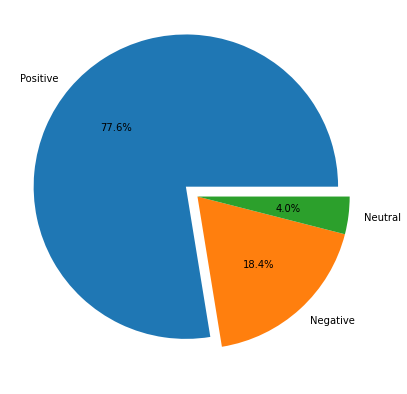

In [ ]:
swn_counts= fin_data['SWN analysis'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(swn_counts.values, labels = swn_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)


([<matplotlib.patches.Wedge at 0x7fe306460d50>,
 [Text(-0.8379737457101502, 0.7126008711056286, 'Positive'),
  Text(0.7424811776501893, -0.8116167204014395, 'Negative'),
  Text(1.3394437864721553, -0.16849434079854303, 'Neutral')],
 [Text(-0.45707658856917277, 0.3886913842394338, '77.6%'),
  Text(0.40498973326373955, -0.44270002930987606, '18.4%'),
  Text(0.8433534951861719, -0.10608902939167522, '4.0%')])

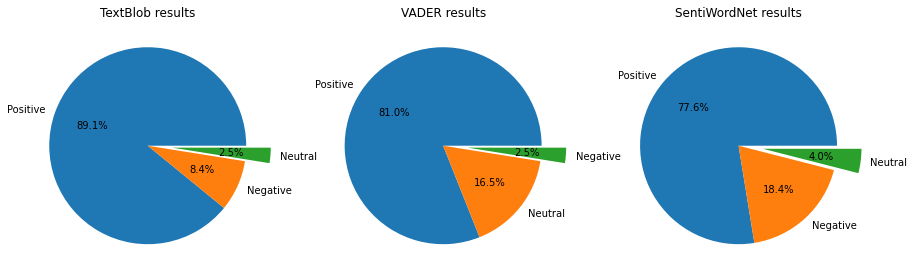

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("TextBlob results")
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER results")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,3)
plt.title("SentiWordNet results")
plt.pie(swn_counts.values, labels = swn_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

# Analisis de sentimiento con sklearn

En esta base de datos tenemos los datos de twitter de clientes de 6 aerolineas de estados unidos. Estos tweets contienen sentimiento positivo, negativo y neutral. 

In [ ]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_source_url = "https://raw.githubusercontent.com/satyajeetkrjha/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)

In [ ]:
airline_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

6.0
4.0


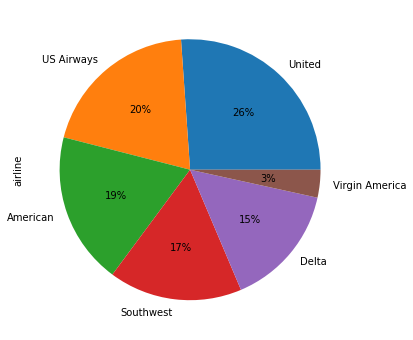

In [ ]:
airline_tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

Si tomamos en cuenta los valores que nos indican arriba, podemos ver que la aerolinea con menor cantidad de tweets es la Virgin America, y la que tiene mayor cantidad es la United.

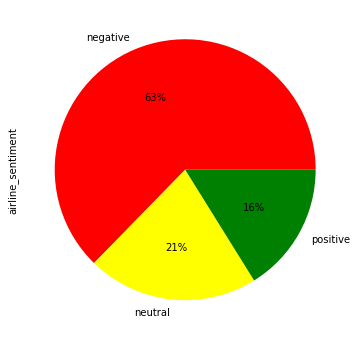

In [ ]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

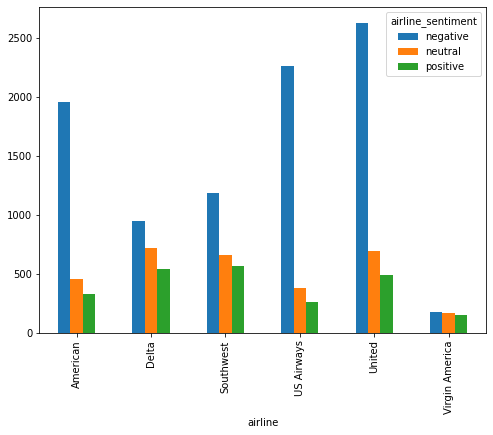

In [ ]:
airline_sentiment = airline_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

Virgin america es la unica que tiene el ratio de sentimiento bastante balanceado.

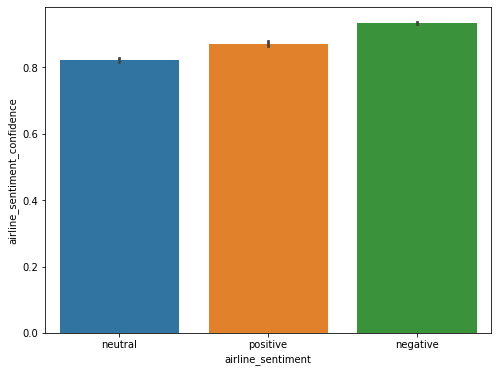

In [ ]:
import seaborn as sns

sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=airline_tweets)

Hay que ser concientes tambien del nivel de confianza que tienen cada uno de los rangos de sentimiento. en la grafica anterior podemos ver que el sentimiento negativo tiene un nivel mas alto de confianza que el positivo y neutro.

In [ ]:
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values

In [ ]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))
    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [ ]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

Usando la libreria de sklearn, randomforestclassifier, podemos entrenar un modelo de aprendizaje de maquina que nos ayuda a predecir el sentimiento del tweet.

In [ ]:
predictions = text_classifier.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[1723  108   39]
 [ 326  248   40]
 [ 132   58  254]]
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.60      0.40      0.48       614
    positive       0.76      0.57      0.65       444

    accuracy                           0.76      2928
   macro avg       0.72      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928

0.7599043715846995


Al final tenemos una exactitud del 75 porciento en la prediccion de analisis de sentimiento, el cual podriamos mejorar si utilizamos otro tipo de modelo, como regresion logistica, Maquina de soporte vectorial y k vecinos.